# CNN Visualizations

Inspired by https://github.com/insikk/Grad-CAM-tensorflow.

In [16]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(grad > 0.0,
                        gen_nn_ops._relu_grad(grad, op.outputs[0]),
                        tf.zeros(grad.get_shape()))

In [2]:
import numpy as np
import skimage
import skimage.io
import skimage.transform
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

def load_image(path, normalize=True, resize=True):
    img = skimage.io.imread(path)
    if normalize:
        img = img / 255.0
        assert (0 <= img).all() and (img <= 1.0).all()

    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    img = img[yy: yy + short_edge, xx: xx + short_edge]

    if resize:
        img = skimage.transform.resize(img, (224, 224), preserve_range=True)
        
    return img

def get_data(img_path, label_id):
    img = load_image(img_path)
    label = np.array([1 if i == label_id else 0 for i in range(1000)])
    
    batch_img = np.expand_dims(img, axis=0)
    batch_label = np.expand_dims(label, axis=0)
    
    return batch_img, batch_label

def image_viz(img):
    img = img.astype(float)
    img -= np.min(img)
    img /= img.max()
    return img

def grad_cam_viz(conv_output, conv_grad, height=224, width=224):
    alpha = np.mean(conv_grad, axis=(0, 1))
    lin_comb = np.sum(np.multiply(alpha[np.newaxis, np.newaxis, :], conv_output), axis=2)
    grad_cam = np.maximum(lin_comb, 0)
    
    grad_cam = grad_cam / np.max(grad_cam)
    grad_cam = skimage.transform.resize(grad_cam, (height, width), preserve_range=True)

    return grad_cam

def guided_backpropagation_viz(gb):      
    gb -= np.min(gb)
    gb /= gb.max()
    return gb

def guided_grad_cam_viz(gd, gc):
    gc = np.expand_dims(gc, axis=2)
    return np.multiply(gd, gc)

def visualize_all(img, conv_output, conv_grad, gb_viz):
    fig = plt.figure(figsize=(16, 20))
    
    img_viz = image_viz(img)
    ax = fig.add_subplot(141)
    imgplot = plt.imshow(img_viz)
    ax.set_title('Input Image')
    
    gb_viz = guided_backpropagation_viz(gb_viz)
    ax = fig.add_subplot(142)
    imgplot = plt.imshow(gb_viz)
    ax.set_title('Guided Backpropagation')
    
    gc = grad_cam_viz(conv_output, conv_grad)  
    ax = fig.add_subplot(143)
    imgplot = plt.imshow(gc, cmap=plt.get_cmap("jet"))
    ax.set_title('Grad-CAM')    
           
    gd_gc_viz = guided_grad_cam_viz(gb_viz, gc)
    ax = fig.add_subplot(144)
    imgplot = plt.imshow(gd_gc_viz)
    ax.set_title('Guided Grad-CAM')

    plt.show()
    
def print_prob(prob, file_path):
    synset = [l.strip() for l in open(file_path).readlines()]
    pred = np.argsort(prob)[::-1]

    # Get top1 label
    top1 = synset[pred[0]]
    print("Top1: ", top1, prob[pred[0]])

    # Get top5 label
    top5 = [(synset[pred[i]], prob[pred[i]]) for i in range(5)]
    print("Top5: ", top5)
    
    return top1

def normalize(x):
    x = x - np.min(x)
    return x/np.max(x)

In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from model import vgg16

batch_img, batch_label = get_data("demo.png", label_id=242)
batch_size, height, width, channel = batch_img.shape

eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        images = tf.placeholder(tf.float32, [batch_size, height, width, channel])
        labels = tf.placeholder(tf.float32, [batch_size, 1000])

        vgg = vgg16.Vgg16(trainable=False)
        vgg.build(images)
        
        # COMPUTE COST
        # labels (1, 1000) one hot encoding
        # vgg.prob (1, 1000)
        # cost (1,)
        cost = -1.0 * tf.reduce_sum(tf.multiply(labels, tf.log(vgg.prob)), axis=1)

        # GUIDED BACKPROPAGATION
        # requires Guided ReLU
        # ∂cost/∂images
        gb_grad = tf.gradients(cost, images)[0]
        
        # GRAD-CAM
        # gradient for partial linearization
        # vgg.fc (1, 1000) last fully-connected layed
        # labels (1, 1000) one hot encoding
        # y_c (1, )
        y_c = tf.reduce_sum(tf.multiply(vgg.fc8, labels), axis=1)

        # ∂y_c/∂vgg.pool5
        # y_c (1, )
        # vgg.pool5 (1, 7, 7, 512) last layer before fully-connected layers
        # target_layer_grad (1, 7, 7, 512)
        target_layer = vgg.pool5
        target_layer_grad = tf.gradients(y_c, vgg.pool5)[0]

        init = tf.global_variables_initializer()

## Filters in the first layer `conv1_1`

In [4]:
with tf.Session(graph=eval_graph) as sess:
    sess.run(init)
    conv1_1_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='conv1_1')[0]
    conv1_1 = sess.run(conv1_1_var, feed_dict={images: batch_img, labels: batch_label})

Shape of filters from the first convolutional layer `conv1_1`

In [5]:
conv1_1.shape

(3, 3, 3, 64)

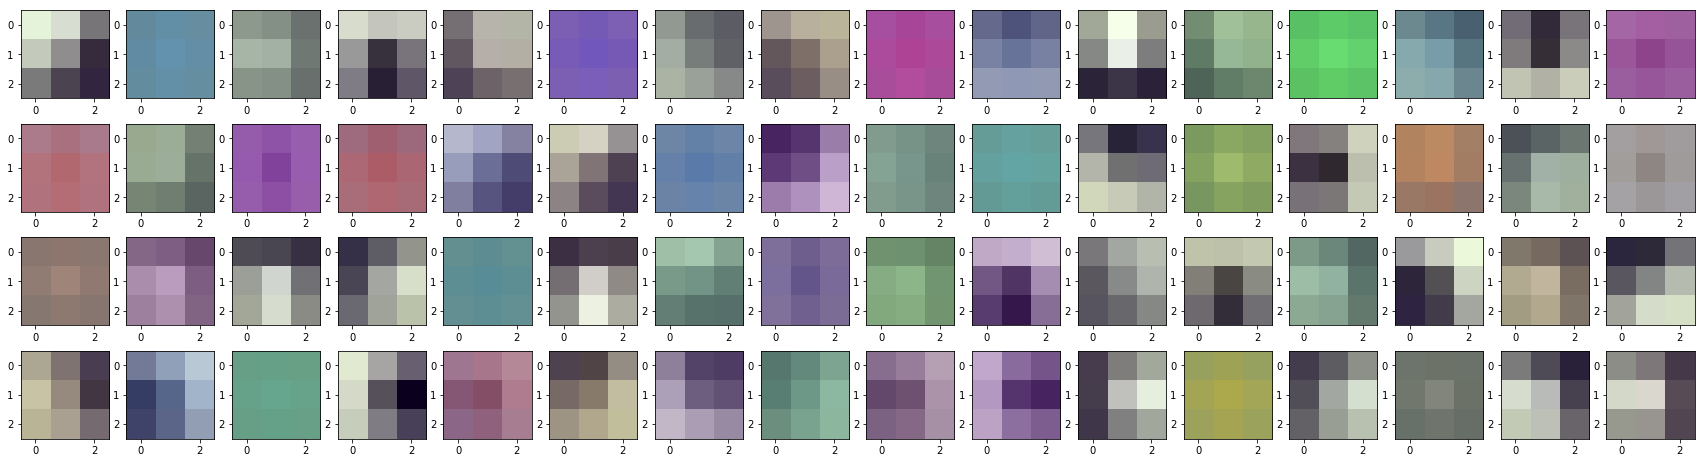

In [6]:
fig = plt.figure(figsize=(30, 8))
conv1_1_norm = normalize(conv1_1)
for i in range(conv1_1_norm.shape[3]):
    kernel_B = conv1_1_norm[:, :, 0, i]
    kernel_G = conv1_1_norm[:, :, 1, i]
    kernel_R = conv1_1_norm[:, :, 2, i]
    kernel = np.dstack([kernel_R, kernel_G, kernel_B])
    ax = fig.add_subplot(4, 16, i+1)
    imgplot = plt.imshow(kernel)

## Feature maps produced by the first convolutional layer `conv1_1`

In [7]:
with tf.Session(graph=eval_graph) as sess:
    sess.run(init)
    conv1_1_out = sess.run(vgg.conv1_1, feed_dict={images: batch_img, labels: batch_label})

Shape of output from the first convolutional layer `conv1_1`

In [8]:
conv1_1_out.shape

(1, 224, 224, 64)

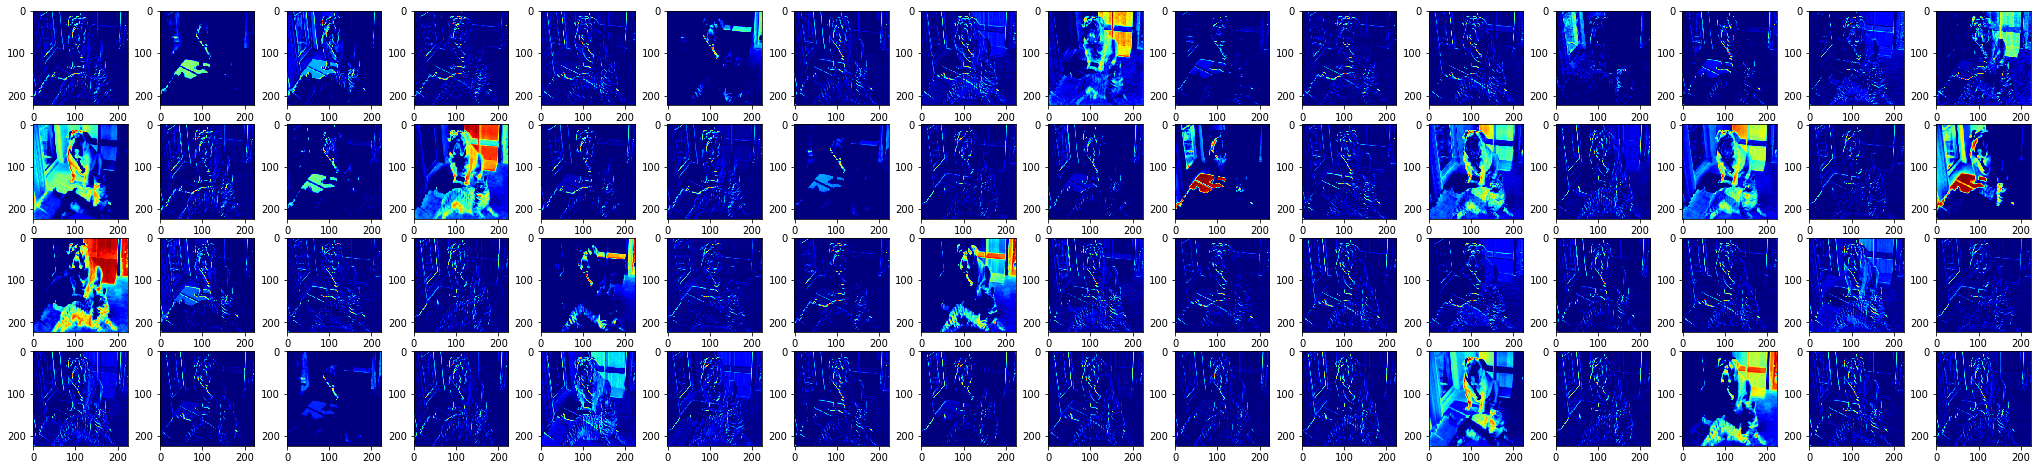

In [9]:
fig = plt.figure(figsize=(36, 8))
conv1_1_out_norm = normalize(conv1_1_out)

for i in range(conv1_1_out_norm.shape[3]):
    ax = fig.add_subplot(4, 16, i+1)
    imgplot = plt.imshow(conv1_1_out_norm[0,:,:,i], cmap=plt.get_cmap("jet"))

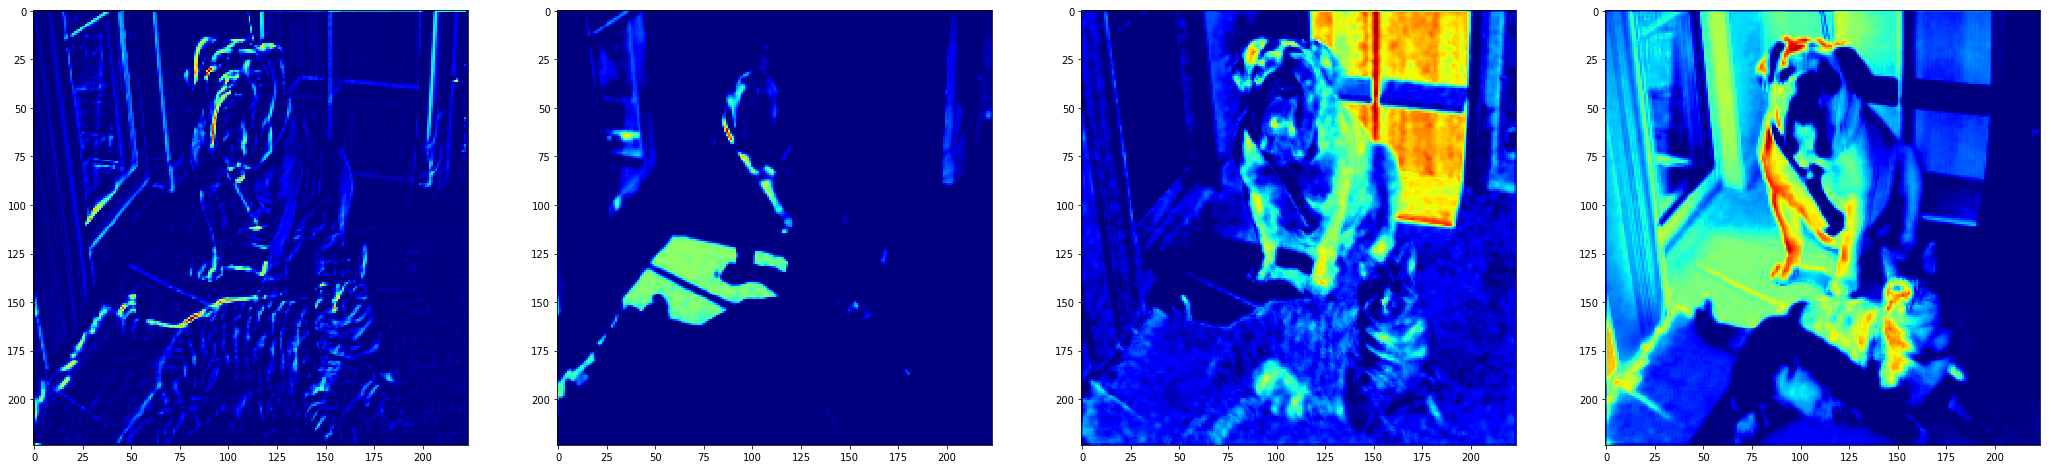

In [10]:
fig = plt.figure(figsize=(36, 8))
conv1_1_out_norm = normalize(conv1_1_out)

for idx, i in enumerate([0, 1, 8, 16]):
    ax = fig.add_subplot(1, 4, idx+1)
    imgplot = plt.imshow(conv1_1_out_norm[0,:,:,i], cmap=plt.get_cmap("jet"))

## Grad-CAM

/fast2/kersner/envs/tf14/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


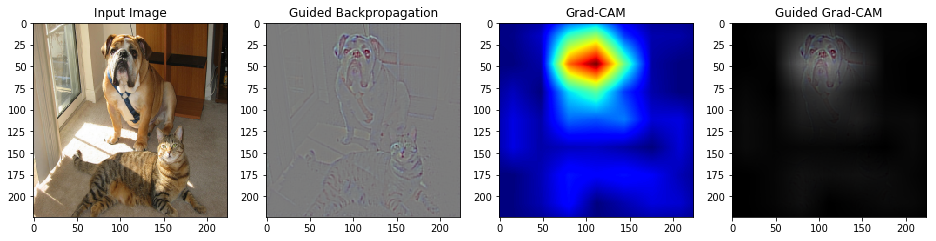

In [20]:
with tf.Session(graph=eval_graph) as sess:    
    sess.run(init)
    
    c, prob, gb_grad_value, target_conv_layer_val, target_conv_layer_grad_val = sess.run(
        [cost, vgg.prob, gb_grad, target_layer, target_layer_grad],
        feed_dict={images: batch_img, labels: batch_label})
    
    for i in range(batch_size):
#         print_prob(prob[i], './synset.txt')
        gradBGR = gb_grad_value[i]
        gradRGB = gradBGR[..., [2,1,0]]
        visualize_all(batch_img[i], target_conv_layer_val[i], target_conv_layer_grad_val[i], gradRGB)